In [1]:
import rasterio as ro
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import random
import math
import pandas
from scipy import optimize

#from keras_tuner.engine.hyperparameters import HyperParameters

from scipy.signal import savgol_filter

In [2]:
# load the data
ndvi = ro.open("Data/NDVI.grd")

covariates = ro.open("Data/covariates_250m_peninsula.grd")

p1 = ro.open("Data/newprec_01.tif")

p7 = ro.open("Data/newprec_07.tif")

fire_history = ro.open("Data/age.grd")

qa_data = ro.open("Data/QA.grd")

In [3]:
# read the shape of covariates
covariates_arr = covariates.read()

np.shape(covariates_arr)

(12, 172, 63)

In [4]:
# read the shape of NDVI
ndvi_arr = ndvi.read()

np.shape(ndvi_arr)

(748, 172, 63)

In [5]:
# read the shape of QA
qa_arr = qa_data.read()

np.shape(qa_arr)

(748, 172, 63)

In [6]:
# read the shape of fire history
fire_arr = fire_history.read()
fire_arr.shape

(748, 172, 63)

In [7]:
fire_arr[0]

array([[   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       ...,
       [   nan,    nan,    nan, ...,  2784.,  2784., 14658.],
       [   nan,    nan,    nan, ...,  2784.,  2784., 14658.],
       [   nan,    nan,    nan, ..., 14658., 14658., 14658.]],
      dtype=float32)

In [8]:
# read the precipitation data
p1_arr = p1.read()
p1_arr.shape
p7_arr = p7.read()
p7_arr.shape

p1_arr = p1_arr[:,:172,:63]

p7_arr = p7_arr[:,:172,:63]

In [9]:
p1_arr[p1_arr<0] = np.nan 
p7_arr[p7_arr<0] = np.nan 

In [10]:
# replace the precipitation value
covariates_arr[9] = p1_arr
covariates_arr[10] = p7_arr

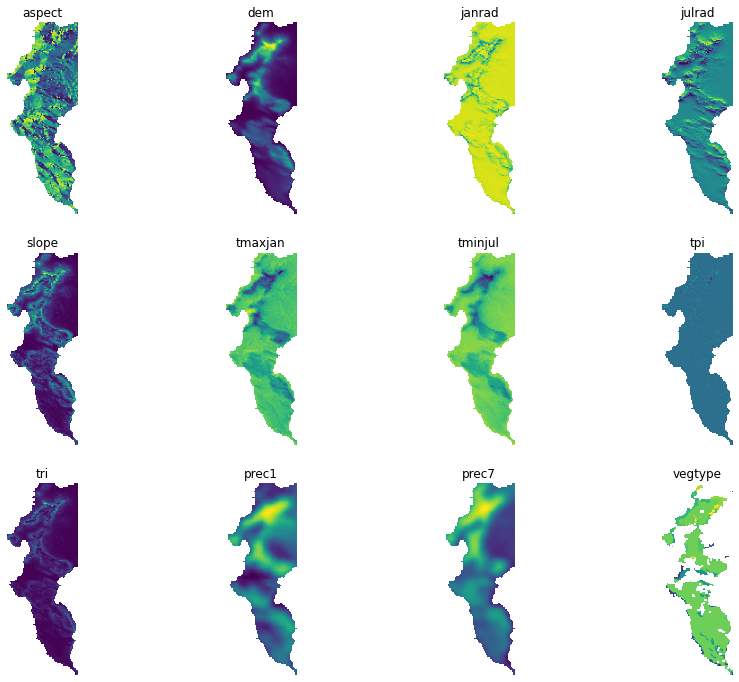

In [11]:
# Visualize the environment covariates
plt.figure(figsize=(15,12))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.title(covariates.descriptions[i])
    plt.imshow(covariates_arr[i])
    plt.axis('off')

In [12]:
# read the shape of new covariates 
np.shape(covariates_arr)

(12, 172, 63)

In [13]:
# What is the value range of the environmental variables?
for i in range(covariates_arr.shape[0]):
    layer_name = covariates.descriptions[i]
    min_value = np.nanmin(covariates_arr[i])
    max_value = np.nanmax(covariates_arr[i])
    mean_value = np.nanmean(covariates_arr[i])
    print(layer_name+": min: "+str(min_value)+", max: "+str(max_value)+", mean: "+str(mean_value)+"\n")

aspect: min: 0.025960453, max: 6.2611136, mean: 3.0046475

dem: min: -1.2942011, max: 1069.7134, mean: 172.9334

janrad: min: 4004.0354, max: 9311.947, mean: 8741.644

julrad: min: 471.11484, max: 6528.9673, mean: 3281.7493

slope: min: 6.7596327e-22, max: 1.2136732, mean: 0.2010844

tmaxjan: min: 21.831682, max: 31.777122, mean: 28.34501

tminjul: min: 3.6588407, max: 11.716162, mean: 9.477635

tpi: min: -25.07602, max: 42.91772, mean: 0.050585095

tri: min: 1.2236242e-19, max: 244.41881, mean: 17.412844

prec1: min: 16.0, max: 32.981983, mean: 22.70195

prec7: min: 80.15998, max: 169.64435, mean: 117.04249

vegtype: min: 2.0, max: 20.0, mean: 14.957029



In [14]:
def MaxMinNormalization(x, norm_min, norm_max):
    """（0,1] normaliaztion"""
    x = (x - norm_min) / (norm_max - norm_min)
    return x

In [15]:
# normalize the covariate data
norm_covariates = np.zeros(covariates_arr.shape)
for i in range(12):
    norm_covariates[i] = MaxMinNormalization(covariates_arr[i],np.nanmin(covariates_arr[i])-1,np.nanmax(covariates_arr[i])+1)
print(norm_covariates.shape)

(12, 172, 63)


In [16]:
# normalize the fire history data
norm_fire = np.zeros(fire_arr.shape)
for i in range(748):
    norm_fire[i] = MaxMinNormalization(fire_arr[i],np.nanmin(fire_arr[i])-1,np.nanmax(fire_arr[i])+7300)
print(norm_fire.shape)

(748, 172, 63)


In [17]:
norm_fire[0]

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ..., 0.12615076, 0.12615076,
        0.66730469],
       [       nan,        nan,        nan, ..., 0.12615076, 0.12615076,
        0.66730469],
       [       nan,        nan,        nan, ..., 0.66730469, 0.66730469,
        0.66730469]])

In [18]:
# What is the value range of the NORMALIZED environmental variables?
for i in range(norm_covariates.shape[0]):
    layer_name = covariates.descriptions[i]
    min_value = np.nanmin(norm_covariates[i])
    max_value = np.nanmax(norm_covariates[i])
    mean_value = np.nanmean(norm_covariates[i])
    print(layer_name+": min: "+str(min_value)+", max: "+str(max_value)+", mean: "+str(mean_value)+"\n")

aspect: min: 0.1214306503534317, max: 0.8785693645477295, mean: 0.48313456580264563

dem: min: 0.0009319598902948201, max: 0.999068021774292, mean: 0.16330510320843938

janrad: min: 0.00018832703062798828, max: 0.9998116493225098, mean: 0.8924082571804849

julrad: min: 0.00016502052312716842, max: 0.9998349547386169, mean: 0.4639774106588817

slope: min: 0.31117042899131775, max: 0.6888296008110046, mean: 0.3737419339288029

tmaxjan: min: 0.08371394872665405, max: 0.916286051273346, mean: 0.6289705463014474

tminjul: min: 0.09943005442619324, max: 0.9005699753761292, mean: 0.6779932413030669

tpi: min: 0.014286991208791733, max: 0.985713005065918, mean: 0.37327056577691187

tri: min: 0.0040581319481134415, max: 0.9959418773651123, mean: 0.07472174343360968

prec1: min: 0.052681535482406616, max: 0.9473184943199158, mean: 0.40575049582622397

prec7: min: 0.010930829681456089, max: 0.9890691637992859, mean: 0.4140873334682927

vegtype: min: 0.05000000074505806, max: 0.949999988079071, me

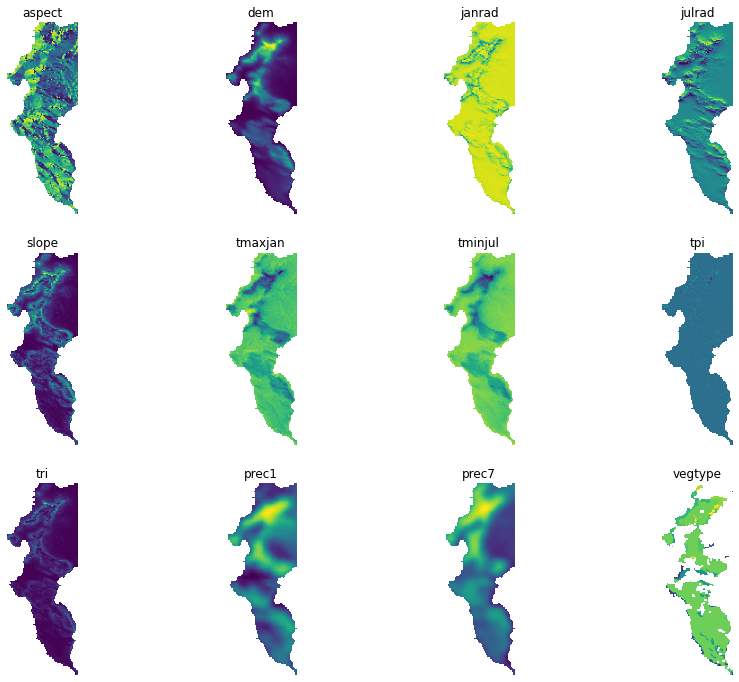

In [19]:
# Visualize the NORMALIZED environment covariates
plt.figure(figsize=(15,12))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.title(covariates.descriptions[i])
    plt.imshow(norm_covariates[i])
    plt.axis('off')

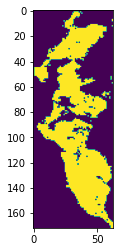

In [20]:
# create a mask based on the environmental variables and fire history
study_region_mask = np.zeros((ndvi.height,ndvi.width))


for i in range(study_region_mask.shape[0]):
    for j in range(study_region_mask.shape[1]):
        found_nan = False
        for var_index in range(covariates_arr.shape[0]):
            if np.isnan(covariates_arr[var_index,i,j]):
                found_nan =True
                break

        for time_step in range(fire_arr.shape[0]):
            if np.isnan(fire_arr[time_step,i,j]):
                found_nan =True
                break
        
        if found_nan:
            study_region_mask[i,j] = -1
        else:
            study_region_mask[i,j] = 1

plt.imshow(study_region_mask)

In [21]:
nan_value = 0

In [22]:
# a mask out function
def mask_layer(input_layer, mask_layer):
    # for i in range(mask_layer.shape[0]):
    #     for j in range(mask_layer.shape[1]):
    #         if mask_layer[i,j]==-1:
    #             input_layer[i,j] = nan_value # replace the nan value in the input data
    input_layer[mask_layer==-1] = nan_value

    return input_layer

In [23]:
#savgol_filter to smooth the data
#ndvi_times = range(1,ndvi.count+1)

qa_value_array = qa_data.read()

#ndvi_smoothed = []
smoothed_dataset = np.zeros((ndvi.count,ndvi.height,ndvi.width))

for m in range(0,ndvi.height):
  for n in range(0,ndvi.width):

    ndvi_ori = ndvi_arr[:,m,n]
    
    if study_region_mask[m,n] ==-1:
      #ndvi_smoothed.append(ndvi_ori)
      smoothed_dataset[:,m,n] = ndvi_ori
      continue
    
    
    qa_value = qa_arr[:,m,n]
    # for i in ndvi_times:
    #   ndvi_data = ndvi.read(i)
    #   ndvi_pixel = ndvi_data[m,n]
    #   ndvi_ori.append(ndvi_pixel) 


    #   qa = qa_data.read(i)
    #   qa_pixel = qa[m,n]
    #   qa_value.append(qa_pixel) 

    smoothed = savgol_filter(ndvi_ori,7,2)

    for t in range(qa_value.shape[0]):
      if qa_value[t] == 0 and ndvi_ori[t]>0:
        smoothed[t] = ndvi_ori[t]
      # else:
      #   pass

    #ndvi_smoothed.append(smoothed)
    smoothed_dataset[:,m,n] = smoothed


#ndvi_smoothed = np.asarray(ndvi_smoothed)

In [24]:
#np.shape(ndvi_smoothed)

In [25]:
# created the dataset contains ONLY SMOOTHED NDVI DATA
# smoothed_dataset = np.zeros((ndvi.count,ndvi.height,ndvi.width))
# for time_steps in range(0,ndvi.count):
#   for m in range(0,ndvi.height):
#     for n in range(0,ndvi.width):
#       smoothed_dataset[time_steps,m,n] = ndvi_smoothed[63*m+n][time_steps]

print(np.shape(smoothed_dataset))

(748, 172, 63)


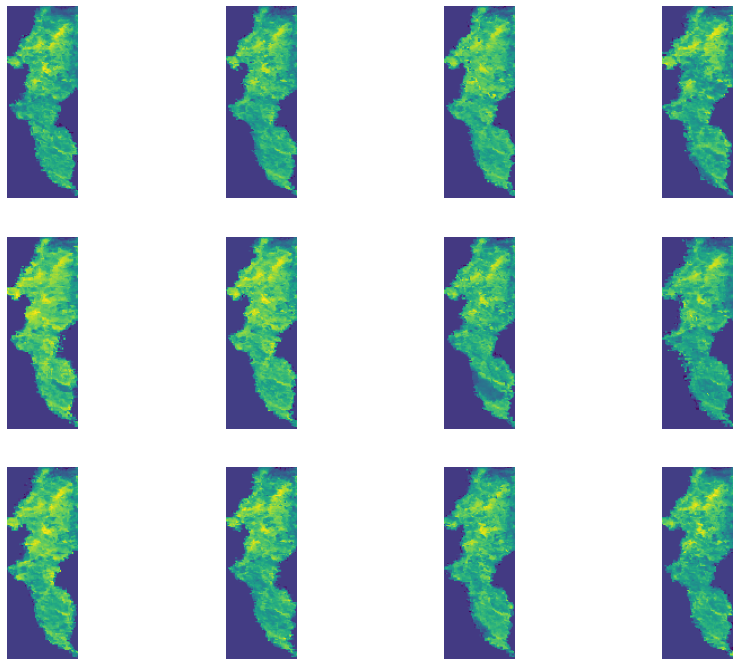

In [26]:
# visualize random 12 NDVI values of SMOOTHED NDVI DATASET
plt.figure(figsize=(15,12))
for i in range(1,13):
    plt.subplot(3,4,i)
    random_time = random.randint(0,ndvi.count-1)
    plt.imshow(smoothed_dataset[random_time,:,:])
    plt.axis('off')

In [27]:
# create multi_input dataset
norm_smoothed_dataset = np.zeros((ndvi.count,ndvi.height,ndvi.width,12))

for time_steps in range(0,ndvi.count):
    norm_smoothed_dataset[time_steps,:,:,0] = smoothed_dataset[time_steps,:,:] #NDVI

    norm_smoothed_dataset[time_steps,:,:,1] = norm_covariates[0,:,:] # aspect
    norm_smoothed_dataset[time_steps,:,:,2] = norm_covariates[1,:,:] # DEM
    norm_smoothed_dataset[time_steps,:,:,3] = norm_covariates[2,:,:] # janrad
    norm_smoothed_dataset[time_steps,:,:,4] = norm_covariates[3,:,:] # julrad
    #norm_smoothed_dataset[time_steps,:,:,4] = norm_covariates[4,:,:] # slope
    norm_smoothed_dataset[time_steps,:,:,5] = norm_covariates[5,:,:] # tmaxjan
    norm_smoothed_dataset[time_steps,:,:,6] = norm_covariates[6,:,:] # tminjul
    norm_smoothed_dataset[time_steps,:,:,7] = norm_covariates[7,:,:] # tpi
    norm_smoothed_dataset[time_steps,:,:,8] = norm_covariates[8,:,:] # tri
    norm_smoothed_dataset[time_steps,:,:,9] = norm_covariates[9,:,:] # prec1
    norm_smoothed_dataset[time_steps,:,:,10] = norm_covariates[10,:,:] # prec7
    #norm_smoothed_dataset[time_steps,:,:,10] = norm_covariates[11,:,:] # vegtype
 
    norm_smoothed_dataset[time_steps,:,:,11] = norm_fire[time_steps,:,:]               


print(norm_smoothed_dataset.shape)


(748, 172, 63, 12)


In [28]:
# What is the value range of the NORMALIZED SMOOTHED dataset before the mask
for i in range(1,11):
    layer_name = int(i)
    min_value = np.nanmin(norm_smoothed_dataset[:,:,:,i])
    max_value = np.nanmax(norm_smoothed_dataset[:,:,:,i])
    mean_value = np.nanmean(norm_smoothed_dataset[:,:,:,i])
    print(str(layer_name)+": min: "+str(min_value)+", max: "+str(max_value)+", mean: "+str(mean_value)+"\n")

1: min: 0.1214306503534317, max: 0.8785693645477295, mean: 0.48313456580264563

2: min: 0.0009319598902948201, max: 0.999068021774292, mean: 0.16330510320844016

3: min: 0.00018832703062798828, max: 0.9998116493225098, mean: 0.8924082571804762

4: min: 0.00016502052312716842, max: 0.9998349547386169, mean: 0.46397741065888853

5: min: 0.08371394872665405, max: 0.916286051273346, mean: 0.6289705463014474

6: min: 0.09943005442619324, max: 0.9005699753761292, mean: 0.6779932413030669

7: min: 0.014286991208791733, max: 0.985713005065918, mean: 0.37327056577691187

8: min: 0.0040581319481134415, max: 0.9959418773651123, mean: 0.07472174343360968

9: min: 0.052681535482406616, max: 0.9473184943199158, mean: 0.40575049582622397

10: min: 0.010930829681456089, max: 0.9890691637992859, mean: 0.4140873334682927



In [29]:
# filter the multi_input dataset with the mask
for time_steps in range(0,norm_smoothed_dataset.shape[0]):
    norm_smoothed_dataset[time_steps,:,:,:] = mask_layer(norm_smoothed_dataset[time_steps,:,:,:],study_region_mask)

print(norm_smoothed_dataset.shape)

(748, 172, 63, 12)


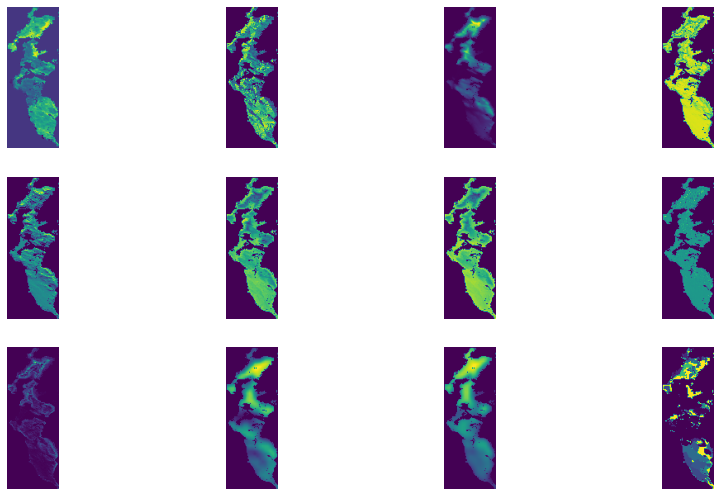

In [30]:
# Visualize the NORMALIZED and masked variables
plt.figure(figsize=(15,12))
figure_names = ["NDVI"]
for i in range(11):
    figure_names.append(covariates.descriptions[i+1])
figure_names.append("Fire age")

for i in range(12):
    plt.subplot(4,4,i+1)
    #plt.title(figure_names[i])
    plt.imshow(norm_smoothed_dataset[0,:,:,i])
    plt.axis('off')

In [31]:
# What is the value range of the NORMALIZED SMOOTHED dataset after the mask
for i in range(1,11):
    layer_name = int(i)
    min_value = np.nanmin(norm_smoothed_dataset[:,:,:,i])
    max_value = np.nanmax(norm_smoothed_dataset[:,:,:,i])
    mean_value = np.nanmean(norm_smoothed_dataset[:,:,:,i])
    print(str(layer_name)+": min: "+str(min_value)+", max: "+str(max_value)+", mean: "+str(mean_value)+"\n")

1: min: 0.0, max: 0.8766118288040161, mean: 0.1871742860126337

2: min: 0.0, max: 0.999068021774292, mean: 0.0878697360836163

3: min: 0.0, max: 0.9998116493225098, mean: 0.3309629230098933

4: min: 0.0, max: 0.9998349547386169, mean: 0.1728341373142324

5: min: 0.0, max: 0.9015579223632812, mean: 0.22608281924479032

6: min: 0.0, max: 0.8692363500595093, mean: 0.24528126100173797

7: min: 0.0, max: 0.6976239681243896, mean: 0.14182202577745304

8: min: 0.0, max: 0.9333016872406006, mean: 0.03708200562367509

9: min: 0.0, max: 0.9473184943199158, mean: 0.16720470398404572

10: min: 0.0, max: 0.9890691637992859, mean: 0.17955702709961627



In [32]:
min_value = np.nanmin(norm_smoothed_dataset[:,:,:,0])
max_value = np.nanmax(norm_smoothed_dataset[:,:,:,0])

print(min_value)
print(max_value)

-0.164983332157135
1.0152380466461182


In [33]:
min_value = np.nanmin(norm_smoothed_dataset[:,:,:,11])
max_value = np.nanmax(norm_smoothed_dataset[:,:,:,11])

print(min_value)
print(max_value)

0.0
0.7381447553634644


convLSTM part

In [34]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

In [35]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [36]:
tf.random.set_seed(42)

In [37]:

def create_model():
    tf.random.set_seed(42)

    convLSTM_model = keras.Sequential(
        [
            #keras.Input(shape=(None, 172, 63, 1)),  # Variable-length sequence of 172x63x1 frames
            layers.InputLayer(input_shape=(None, ndvi.height, ndvi.width, 12)),
            layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding="same", return_sequences=True),
            #layers.BatchNormalization(),
            layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding="same", return_sequences=True),
            #layers.BatchNormalization(),
            layers.ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True),
            #layers.BatchNormalization(),
            layers.ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=True),
            #layers.BatchNormalization(),
            layers.Conv3D(filters=1, kernel_size=(3, 3, 3), padding="same", activation="linear")
        ]
    )
    convLSTM_model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam())
    return convLSTM_model



In [38]:
# Generate training data
# So we are going to use 75% of the data for training and 25% for testing
# step length is 15


training_size = int(ndvi.count * 0.75) # 561

initial_ndvi = []
next_ndvi = []

for sample_i in range(0,training_size-15):
    #initial_index = random.randint(1,(training_size-16))
    
    this_initial_sequence = []
    this_next_sequence = []
    for t in range(0,15): # each sample has 15 time steps
        #this_initial = ndvi.read(initial_index + t)
        this_initial = norm_smoothed_dataset[sample_i + t,:,:,:]
        #this_initial = this_initial[..., np.newaxis]
        this_initial_sequence.append(this_initial)
        
        #this_next = ndvi.read(initial_index + t +1)
        this_next = norm_smoothed_dataset[sample_i + t + 1,:,:,0]
        this_next = this_next[..., np.newaxis]
        this_next_sequence.append(this_next)
        
    initial_ndvi.append(this_initial_sequence)
    next_ndvi.append(this_next_sequence)
    

initial_ndvi = np.asarray(initial_ndvi)
next_ndvi = np.asarray(next_ndvi)


In [39]:
initial_ndvi.shape, next_ndvi.shape

((546, 15, 172, 63, 12), (546, 15, 172, 63, 1))

In [40]:
callback = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3)
#Train the model
convLSTM_model = create_model()

epochs = 70  

history = convLSTM_model.fit(
    initial_ndvi,
    next_ndvi,
    batch_size=5,
    epochs=epochs,
    verbose=1,
    validation_split=0.1,
    callbacks=[callback]
)

convLSTM_model.save('PretrainedModel/ConvLSTM_smoothed_NDVI_all_variables_without_slope_vegtype_linearactivate.h5')


Epoch 1/70
99/99 [==============================] - 341s 3s/step - loss: 0.0157 - val_loss: 0.0049
Epoch 2/70
99/99 [==============================] - 280s 3s/step - loss: 0.0038 - val_loss: 0.0027
Epoch 3/70
99/99 [==============================] - 282s 3s/step - loss: 0.0023 - val_loss: 0.0019
Epoch 4/70
99/99 [==============================] - 283s 3s/step - loss: 0.0017 - val_loss: 0.0014
Epoch 5/70
99/99 [==============================] - 282s 3s/step - loss: 0.0013 - val_loss: 0.0011
Epoch 6/70
99/99 [==============================] - 283s 3s/step - loss: 0.0011 - val_loss: 8.3991e-04
Epoch 7/70
99/99 [==============================] - 283s 3s/step - loss: 7.0888e-04 - val_loss: 6.1490e-04

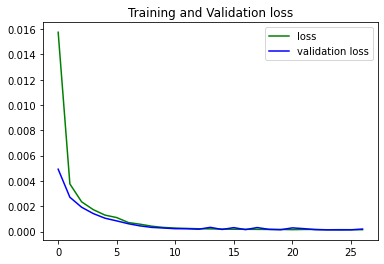

In [41]:
loss_train = history.history["loss"]
loss_val = history.history['val_loss']

plt.plot(loss_train, 'g', label='loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')

plt.legend()
plt.show()

In [42]:
convLSTM_model = tf.keras.models.load_model('PretrainedModel/ConvLSTM_smoothed_NDVI_all_variables_without_slope_vegtype_linearactivate.h5')
convLSTM_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, None, 172, 63, 40) 75040     
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 172, 63, 40) 115360    
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 172, 63, 20) 43280     
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, None, 172, 63, 10) 10840     
_________________________________________________________________
conv3d (Conv3D)              (None, None, 172, 63, 1)  271       
Total params: 244,791
Trainable params: 244,791
Non-trainable params: 0
_________________________________________________________________


In [43]:
# create test dataset using the remaining 25% data 
test_data_input = []
test_data_label = []


for sample_i in range(training_size, ndvi.count):
    
    test_data_label.append(norm_smoothed_dataset[sample_i,:,:,0])
    this_initial_sequence = []
    for t in range(sample_i-15,sample_i): # each sample has 15 time steps
        this_initial = norm_smoothed_dataset[t,:,:,:]
        #this_initial = this_initial[..., np.newaxis]
        this_initial_sequence.append(this_initial)
        
    test_data_input.append(this_initial_sequence)
    
    
test_data_input = np.asarray(test_data_input)
test_data_label = np.asarray(test_data_label)


In [44]:
test_data_input.shape, test_data_label.shape

((187, 15, 172, 63, 12), (187, 172, 63))

In [45]:
# Test the model performance based on the generated test data

predicted = convLSTM_model.predict(test_data_input) 
print(np.shape(predicted))

predicted = predicted[::, -1, ::, ::, 0]   
print("the shape of predicted data is " + str(predicted.shape))

(187, 15, 172, 63, 1)
the shape of predicted data is (187, 172, 63)


In [46]:
# find the valid test pixels for RMSE calculation

valid_testlabel = []
valid_predicted = []

for m in range(0,172):
    for n in range(0,63):
        for i in range(561,748):
            if qa_arr[i,m,n] == 0 and ndvi_arr[i,m,n]>0 and study_region_mask[m,n] == 1:
                valid_testlabel.append(test_data_label[i-561,m,n])
                valid_predicted.append(predicted[i-561,m,n])

print(np.shape(valid_testlabel))
print(np.shape(valid_predicted))

(421377,)
(421377,)


In [47]:
# Performance of the ConvLSTM model
from sklearn.metrics import mean_squared_error
rmse =  mean_squared_error(valid_testlabel, valid_predicted, squared=False)
rmse


0.05763413491590007

In [48]:
import sklearn
from sklearn import metrics
r2 = sklearn.metrics.r2_score(valid_testlabel,valid_predicted)
print(r2)

0.7740387719866036


In [49]:
# find valid input data for baseline1
valid_testlabel1 = []
valid_baseline1 = []


for m in range(0,172):
    for n in range(0,63):
        for i in range(561,748):
            if qa_arr[i,m,n] == 0 and ndvi_arr[i,m,n]>0 and study_region_mask[m,n] == 1:
                valid_testlabel1.append(test_data_label[i-561,m,n])
                valid_baseline1.append(test_data_input[i-561,-1,m,n,0])


In [50]:
print(np.shape(valid_baseline1))

print(np.shape(valid_testlabel1))

(421377,)
(421377,)


In [51]:
"""
#baseline #1: simply guess as the same of last step
pred_baseline1 = test_data_input[::, -1, ::, ::, 0]
pred_baseline1.shape
"""

'\n#baseline #1: simply guess as the same of last step\npred_baseline1 = test_data_input[::, -1, ::, ::, 0]\npred_baseline1.shape\n'

In [52]:
"""
# performance of the baseline#1
rmse =  mean_squared_error(test_data_label.flatten(), pred_baseline1.flatten(), squared=False)
rmse
"""

'\n# performance of the baseline#1\nrmse =  mean_squared_error(test_data_label.flatten(), pred_baseline1.flatten(), squared=False)\nrmse\n'

In [53]:
# performance of the baseline#1
rmse =  mean_squared_error(valid_testlabel1, valid_baseline1, squared=False)
rmse

0.06968454444433922

In [54]:
r2 = sklearn.metrics.r2_score(valid_testlabel1,valid_baseline1)
print(r2)

0.6696705462970265


In [55]:
# find valid input data for baseline2
valid_testlabel2 = []
valid_baseline2 = []

for m in range(0,172):
    for n in range(0,63):
        for i in range(561,748):
            if qa_arr[i,m,n] == 0 and ndvi_arr[i,m,n]>0 and study_region_mask[m,n] == 1:
                valid_testlabel2.append(test_data_label[i-561,m,n])
                pred_baseline2 = test_data_input[i-561, ::, m, n, 0]
                valid_baseline2.append(np.mean(pred_baseline2,axis = 0))


print(np.shape(valid_testlabel2))
print(np.shape(valid_baseline2))

(421377,)
(421377,)


In [56]:
"""
# baseline #2: average of the past 15 steps
pred_baseline2 = test_data_input[::, ::, ::, ::, 0]
pred_baseline2 = np.mean(pred_baseline2, axis=1)
pred_baseline2.shape
"""

'\n# baseline #2: average of the past 15 steps\npred_baseline2 = test_data_input[::, ::, ::, ::, 0]\npred_baseline2 = np.mean(pred_baseline2, axis=1)\npred_baseline2.shape\n'

In [57]:
# performance of the baseline#2
rmse =  mean_squared_error(valid_testlabel2, valid_baseline2, squared=False)
rmse

0.06708748252762423

In [58]:
r2 = sklearn.metrics.r2_score(valid_testlabel2,valid_baseline2)
print(r2)

0.6938337188740548


In [59]:
pred_baseline1 = test_data_input[::, -1, ::, ::, 0]
pred_baseline2 = test_data_input[::, ::, ::, ::, 0]

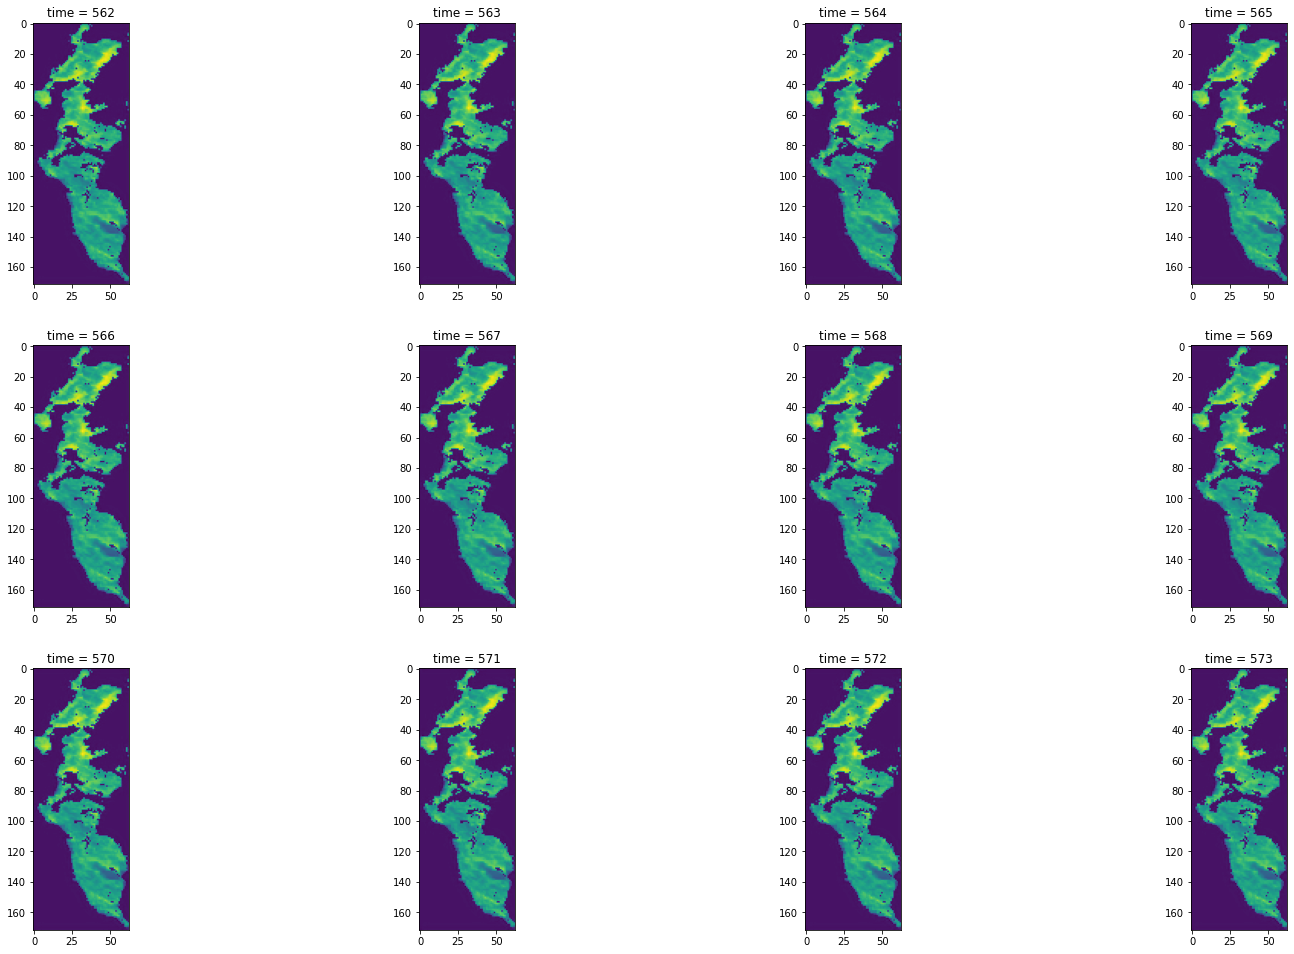

In [60]:
time_steps = range(training_size+1, training_size+1+len(test_data_label))

fig, axes = plt.subplots(3,4, figsize=(22,14))
fig.tight_layout(pad=4.0)
for i in range(1,13):
    plt.subplot(3,4,i)
    #for j in range(1,3):
    predict_series = predicted[j]

    plt.imshow(predict_series)
        #plt.ylim(0.0,1.0)
    plt.title("time = " + str(561+i))

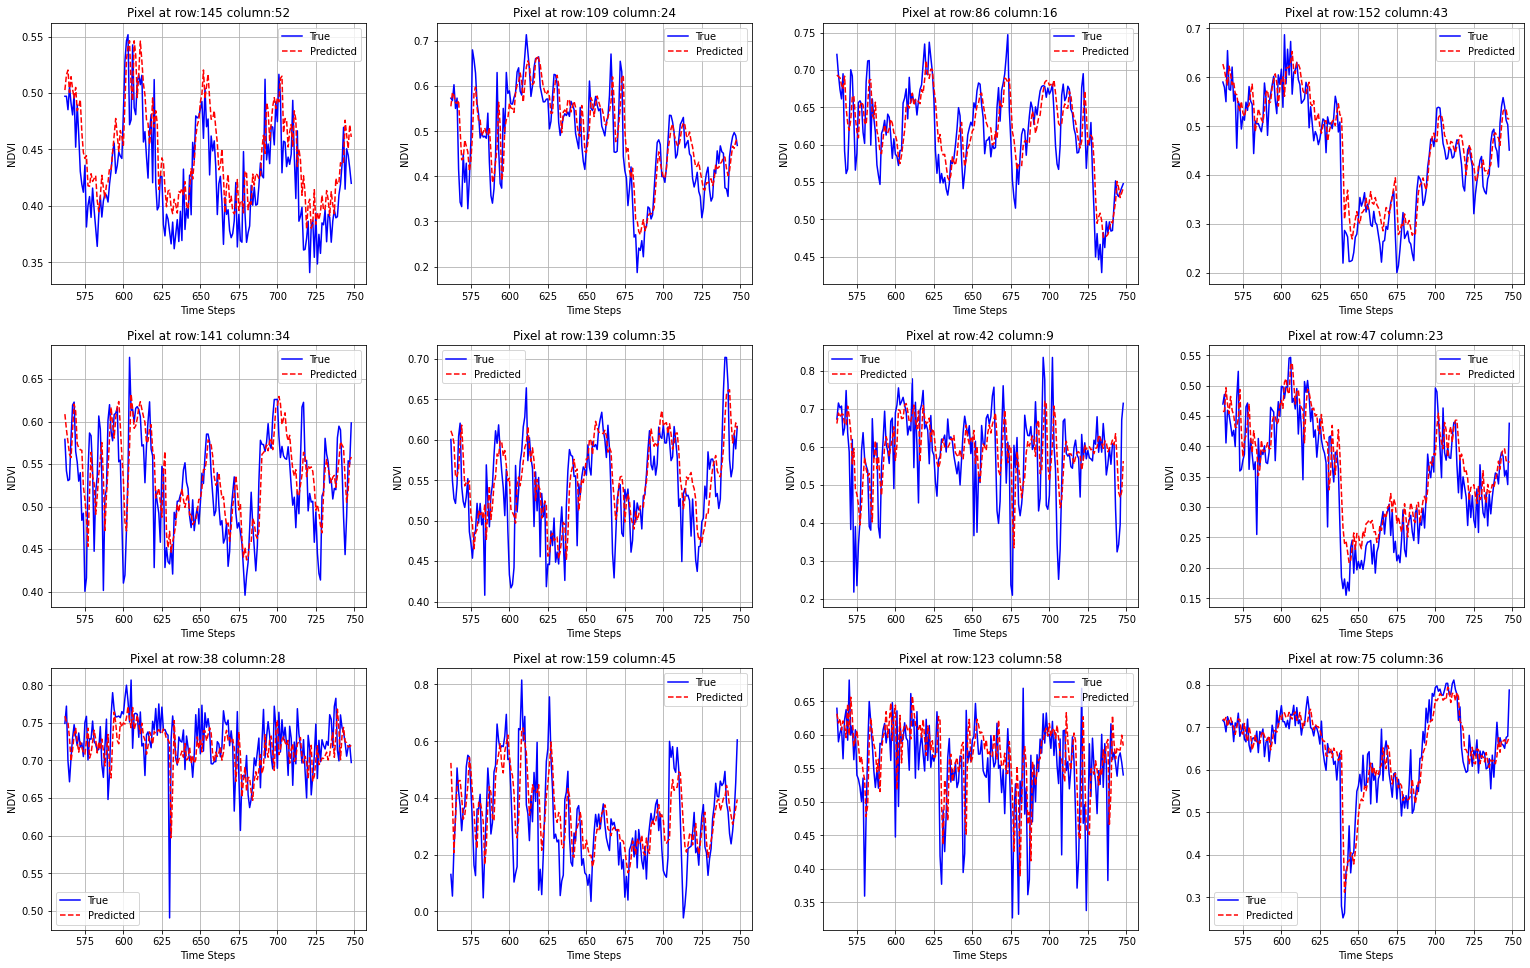

In [61]:
# Visualize the predictions of 12 pixels
time_steps = range(training_size+1, training_size+1+len(test_data_label))

fig, axes = plt.subplots(3,4, figsize=(22,14))
fig.tight_layout(pad=4.0)
for i in range(1,13):
    #for j in range(1,3):

    plt.subplot(3,4,i)

    pixel_y = random.randint(0,ndvi.height-1)
    pixel_x = random.randint(0,ndvi.width-1)

    while study_region_mask[pixel_y,pixel_x] == -1:
        pixel_y = random.randint(0,ndvi.height-1)
        pixel_x = random.randint(0,ndvi.width-1)

    true_series = test_data_label[:,pixel_y,pixel_x]
    predict_series = predicted[:,pixel_y,pixel_x]
    plt.plot(time_steps, true_series,"b-", label='True')
    plt.plot(time_steps, predict_series,"r--", label='Predicted')
    #plt.ylim(0.0,1.0)
    plt.xlabel("Time Steps")
    plt.ylabel("NDVI")
    plt.legend()
    plt.grid('on')
    plt.title('Pixel at row:'+str(pixel_y)+" column:"+str(pixel_x))

In [62]:
# calculate temporal rmse of 12 randomly picked pixels
x = []
y = []
for j in range(1,13):
    pixel_y = random.randint(0,ndvi.height-1)
    pixel_x = random.randint(0,ndvi.width-1)

    while study_region_mask[pixel_y,pixel_x] == -1:
        pixel_y = random.randint(0,ndvi.height-1)
        pixel_x = random.randint(0,ndvi.width-1)

    x.append(pixel_x)
    y.append(pixel_y)

    tem_label = []
    tem_pred = []
    for i in range(561,748):
        if qa_arr[i,pixel_y,pixel_x] == 0 and ndvi_arr[i,pixel_y,pixel_x] > 0:
            tem_label.append(test_data_label[i-561,pixel_y,pixel_x])
            tem_pred.append(predicted[i-561,pixel_y,pixel_x])

    tem_rmse =  mean_squared_error(tem_label, tem_pred, squared=False)
    print("the temporal RMSE of pixel (" + str(pixel_y) + "," + str(pixel_x) +") " + "is " + str(tem_rmse))

the temporal RMSE of pixel (119,30) is 0.048655108148046806
the temporal RMSE of pixel (76,48) is 0.04825961670426225
the temporal RMSE of pixel (125,39) is 0.039356933296438586
the temporal RMSE of pixel (43,32) is 0.043507194729588694
the temporal RMSE of pixel (18,43) is 0.033092011822615224
the temporal RMSE of pixel (102,23) is 0.04752352305286445
the temporal RMSE of pixel (92,45) is 0.0928093778331733
the temporal RMSE of pixel (11,30) is 0.04703327565414765
the temporal RMSE of pixel (124,58) is 0.0574255150545441
the temporal RMSE of pixel (76,40) is 0.043693945851956094
the temporal RMSE of pixel (27,40) is 0.06144621922383678
the temporal RMSE of pixel (100,33) is 0.03730703746948415


In [63]:
# calculate temporal r2 of 12 randomly picked pixels
for j in range(1,13):


    tem_label = []
    tem_pred = []
    for i in range(561,748):
        if qa_arr[i,y[j-1],x[j-1]] == 0 and ndvi_arr[i,y[j-1],x[j-1]] > 0:
            tem_label.append(test_data_label[i-561,y[j-1],x[j-1]])
            tem_pred.append(predicted[i-561,y[j-1],x[j-1]])
    tem_r2 = sklearn.metrics.r2_score(tem_label,tem_pred)
    
    print("the temporal R2 of pixel (" + str(y[j-1]) + "," + str(x[j-1]) +") " + "is " + str(tem_r2))

the temporal R2 of pixel (119,30) is -0.19085214687166063
the temporal R2 of pixel (76,48) is 0.7724144650006958
the temporal R2 of pixel (125,39) is 0.44440955137013294
the temporal R2 of pixel (43,32) is -0.009398873617898706
the temporal R2 of pixel (18,43) is 0.2036844291398221
the temporal R2 of pixel (102,23) is 0.15759215830045792
the temporal R2 of pixel (92,45) is -0.12591168973761424
the temporal R2 of pixel (11,30) is 0.28057386240378623
the temporal R2 of pixel (124,58) is -0.3589417419812164
the temporal R2 of pixel (76,40) is 0.8635277075924512
the temporal R2 of pixel (27,40) is -0.15467671449681641
the temporal R2 of pixel (100,33) is 0.6806503692521833


In [64]:
# calculate per pixel rmse
spatial_rmse = np.random.rand(ndvi.height,ndvi.width)

for i in range(ndvi.height):
    for j in range(ndvi.width):
        this_true = test_data_label[:,i,j]
        this_predict = predicted[:,i,j]
        this_rmse = mean_squared_error(this_true,this_predict, squared=False)
        spatial_rmse[i,j] = this_rmse

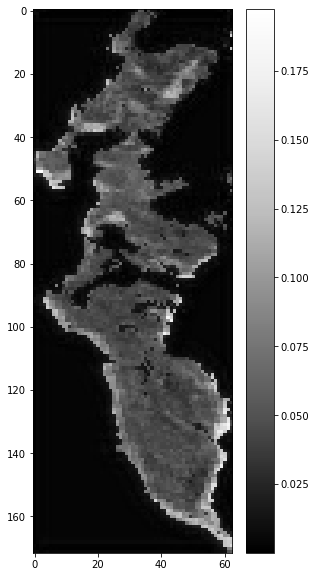

In [65]:
plt.figure(figsize=(5,10))
plt.imshow(spatial_rmse, cmap="Greys_r")
plt.colorbar()